In [1]:
# recall df
%store -r w_df
%store -r w_test
%store -r w_train

## PAKAGES

In [2]:
import numpy as np
import pandas as pd
import math
import statistics
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


# for pattern identification 
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Describing the time series patterns (visually and numerically)

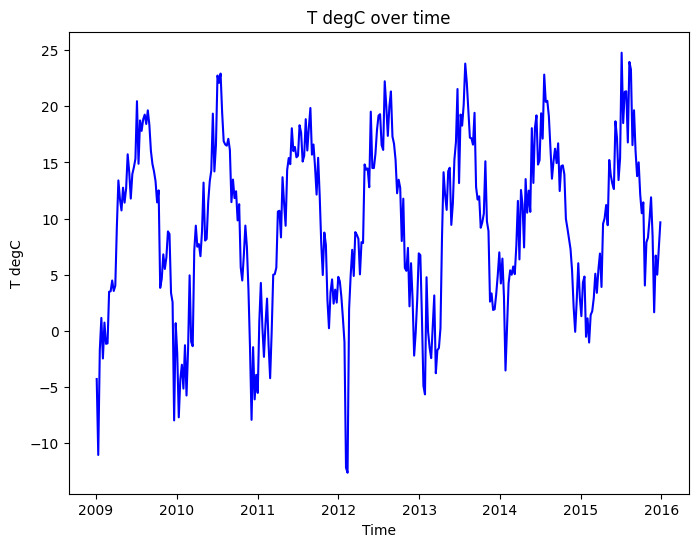

In [3]:
# Since in the next point we are interested in make forecasting about the variable degC
# we only take this in consideration even in this session in which we analyse the series patterns

t_degC_df=w_train['T (degC)']

# we also plot it 
plt.figure(figsize=(8,6))
plt.plot(t_degC_df,color='Blue')
plt.xlabel('Time')
plt.ylabel('T degC')
plt.title('T degC over time')
plt.show()

So from a first look we can notice a **strong seasonal pattern** in this series that can also cover eventual trend and cycle component.
But before analyze seasonality, we want to analyze if the time series is stationaty.

## Stationarity

Stationarity in a time series means that its statistical properties (mean, variance, and autocorrelation) remain constant over time.
Non-stationary series can lead to unreliable model predictions, invalid statistical tests, and spurious correlations.

So we can check it following:

In order to check for the stationarity of a time series, different operations and statistical tests can be done, in particular:

* evaluating rolling statistics (generally mean and standard deviation --> should be stable);
* ACF plot: for a stationary time series the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly;
* Unit root tests: these are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required. ADF (Augmented Dickey-Fuller) and * * KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests are the main ones.

### Rolling statistics

Rolling Statistics is a method that calculates rolling statistics (such as the mean and standard deviation) over a specific time window, which moves across the time series data. Used to observe how the statistical properties (mean and standard deviation) change over time.

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

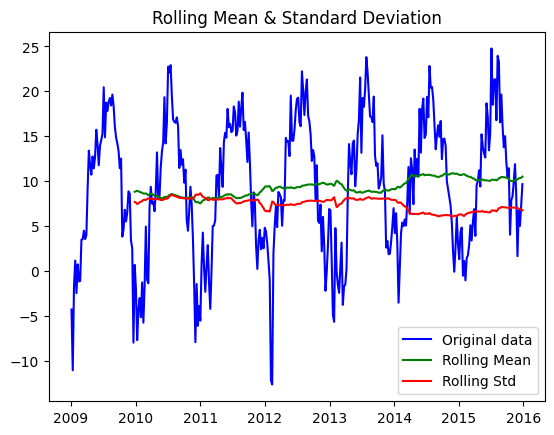

In [4]:
# since the data are weeakely the parameter are the number of the week in one year 52
rolling_mean = t_degC_df.rolling(52).mean()
rolling_std = t_degC_df.rolling(52).std()
plt.plot(t_degC_df, label='Original data',color='Blue')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_std, color='red', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

# Rolling mean and std have a constant behaviour over the years, indeed even if they change over the year this behaviour is then repeated next year.
# This hints towards stationarity

We can see that the mean and variance **have not** high oscillation, but we have it, seams to me similar over time.
This allowed us to think that we colund have a **not stationary** time series since even if the oscillation are small, are present.

But we try other method

### ACF plot
for a stationary time series the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly

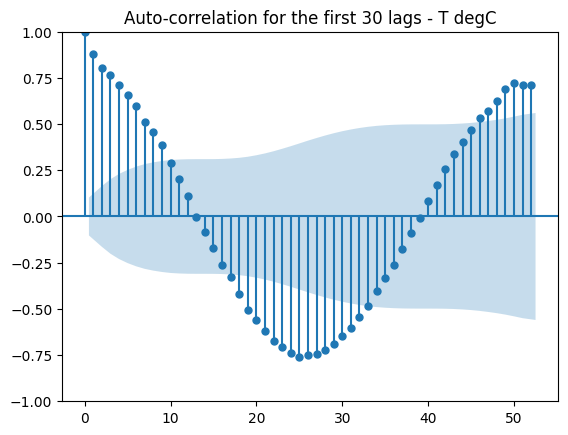

In [5]:
# as lag i still put the numeber of weeks
plot_acf(t_degC_df, lags=52, title='Auto-correlation for the first 30 lags - T degC')
plt.show()

The series is not stationary, because:

* Autocorrelation does not decay rapidly.
* Cyclical or seasonal patterns are observed.
* Significant correlations persist for many lags.

**But mainly**, we have a lots of lags out of bounds.

### UNIT ROOT TESTS: ADF (Augmented Dickey-Fuller) - KPSS (Kwiatkowski-Phillips-Schmidt-Shin) 

 these are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required. 

In [6]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

#Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


###############################################
adfuller_test(t_degC_df)
print('----------------------')
kpss_test(t_degC_df)

ADF Statistic: -7.945514086336788
p-value:  3.2279831966229144e-12
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary
----------------------
KPSS Statistic: 0.020274605447635607
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


C:\Users\lovoa\AppData\Local\Temp\ipykernel_388\348044341.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)


It seems that graph and tests givs us contradittory results, that can be given from the fact that we have strong seasonal component in the data.

What we can conclude from this first analysis is that out time series is **STATIONARY** (test results), even if looking only graph we can have some doubts about this result. 

# Seasnal component 

we try to model the seasonal component in order to find a deseasonalize time series

### 1) Additive model 

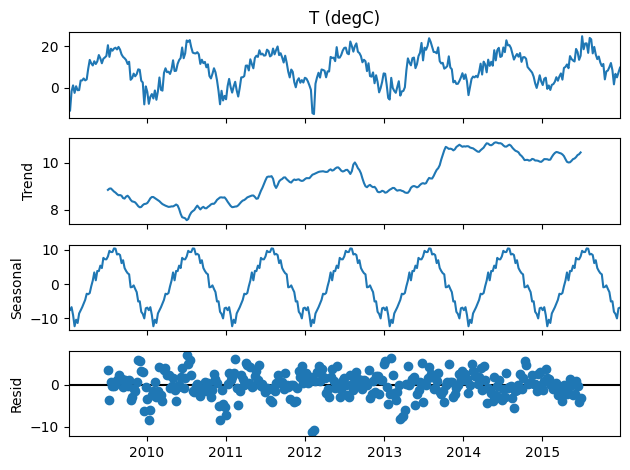

In [7]:
additive_dec=seasonal_decompose(t_degC_df, model='add')
additive_dec.plot()
plt.show()

Multiplicative decomposition is not appropriate for zero and negative values, so we use the **ADDITIVE** one

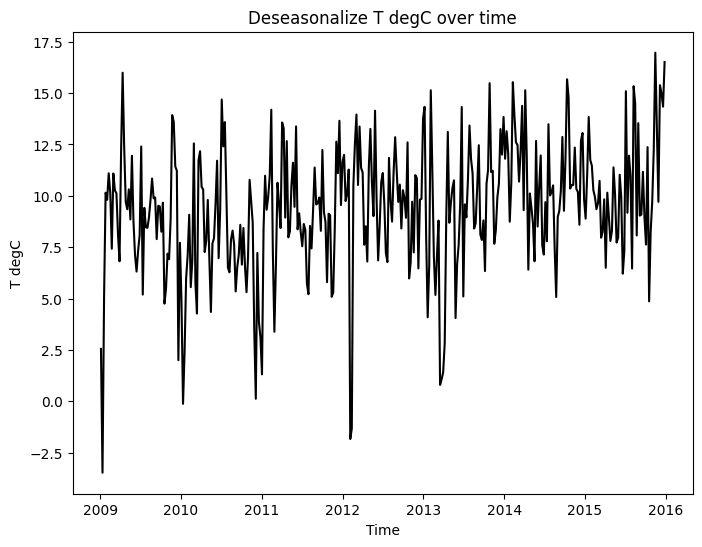

In [8]:
# so now we want to try to deseasonalize

w_train_des= t_degC_df - additive_dec.seasonal

# plot what we obtain 
plt.figure(figsize=(8,6))
plt.plot(w_train_des,color='Black')
plt.xlabel('Time')
plt.ylabel('T degC')
plt.title('Deseasonalize T degC over time')
plt.show()

As we expected the time series shows a less dependecy by seasonality component, since we have delate it

## Repeat stationariety test STATIONARIETY with the **DESEASONAL** time series 

### 1) Rolling statistics_D

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

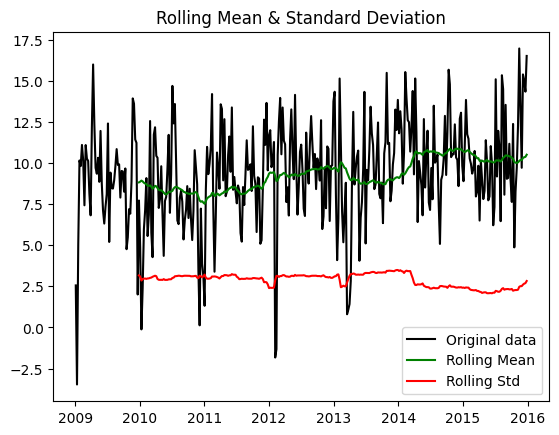

In [9]:
# since the data are weeakely the parameter are the number of the week in one year 52
rolling_mean = w_train_des.rolling(52).mean()
rolling_std = w_train_des.rolling(52).std()
plt.plot(w_train_des, label='Original data',color='Black')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_std, color='red', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

# Rolling mean and std have a constant behaviour over the years, indeed even if they change over the year this behaviour is then repeated next year.
# This hints towards stationarity

From this we can't notice huge differences concerning the trend of the mean and the variance. 

So we conclude the same of the previous series, **Not stationary** time series.

### ACF_D plot

<Figure size 3000x1500 with 0 Axes>

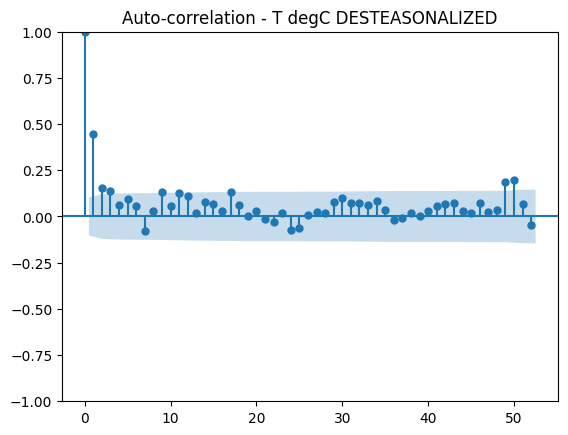

In [10]:
# as lag i still put the numeber of weeks
plt.figure(figsize=(30,15))
plot_acf(w_train_des, lags=52, title='Auto-correlation - T degC DESTEASONALIZED')
plt.show()

<Figure size 1500x1000 with 0 Axes>

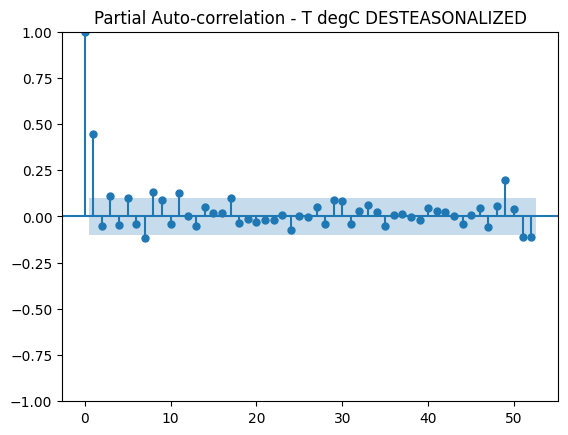

In [11]:
plt.figure(figsize=(15,10))
plot_pacf(w_train_des, lags=52, title='Partial Auto-correlation - T degC DESTEASONALIZED')
plt.show()

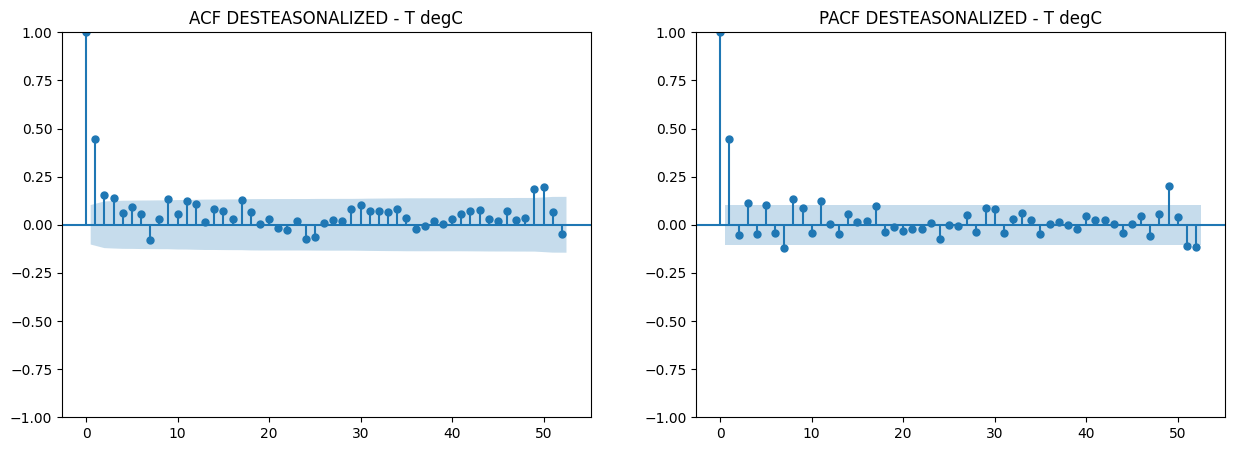

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(w_train_des, lags=52, ax=ax[0], title='ACF DESTEASONALIZED - T degC')
plot_pacf(w_train_des, lags=52, ax=ax[1], title='PACF DESTEASONALIZED - T degC')
plt.show()

In this plot we notice huge differences between the previos one, as we can expected.

In this case we have that the values goes fast to zero and almost all lags are inside the boundaries so we can easely conclude for the **stationariety**.

But again is better to perform the test in order to verify it.

### UNIT ROOT TESTS for DESEASONAL SERIES: ADF (Augmented Dickey-Fuller) - KPSS (Kwiatkowski-Phillips-Schmidt-Shin) 

In [12]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

#Execute a KPSS test on the data passed by the argument. If the p-value is less than 0.05 then null hypothesis cannot be rejected
# and that's means the data is not trend stationary, otherwise is trend stationary.
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


###############################################
adfuller_test(w_train_des)
print('----------------------')
kpss_test(w_train_des)

ADF Statistic: -3.626221379453448
p-value:  0.005279070979238326
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary
----------------------
KPSS Statistic: 0.04617007925662913
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


C:\Users\lovoa\AppData\Local\Temp\ipykernel_388\1658616942.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)


We conclude the same as before, our time series **IS STATIONARY**, but now from a graphic pov the results are more coherent with test.

## DESEASONAL SERIES - using $\nabla=(1-B)^d$

using the **DIFFERENTIATION OPERATOR** for the seasonal component

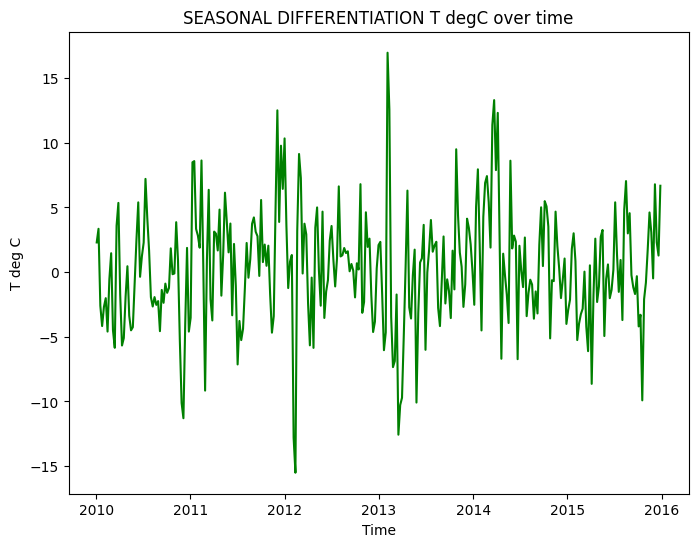

In [13]:
# another way to remove seasonality component is trought the differentiation operator
w_train_seas_diff=t_degC_df.diff(52)

# plot
plt.figure(figsize=(8,6))
plt.plot(w_train_seas_diff,color='Green')
plt.xlabel('Time')
plt.ylabel('T deg C')
plt.title('SEASONAL DIFFERENTIATION T degC over time')
plt.show()

### ACF and PACF deseasonal 

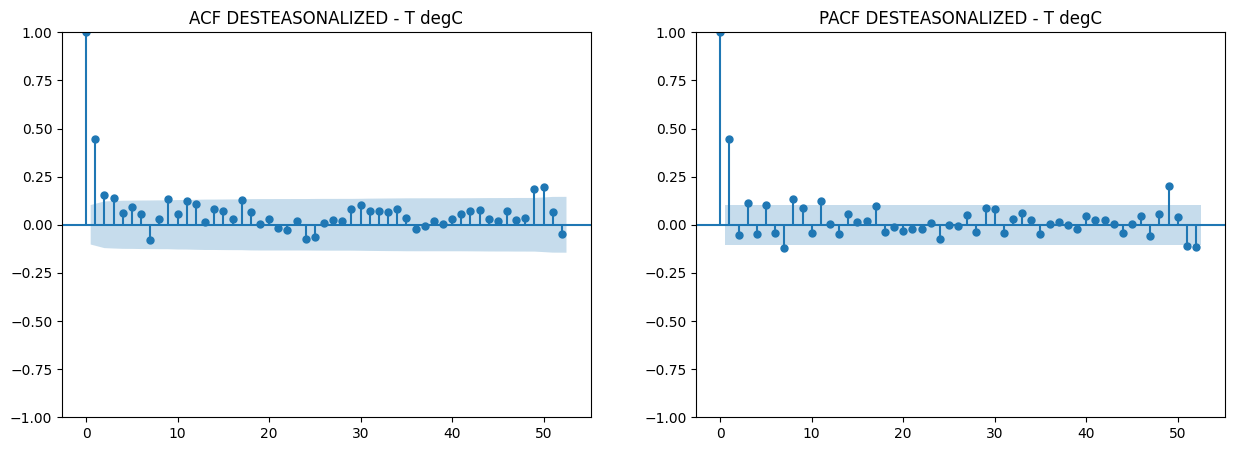

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(w_train_des, lags=52, ax=ax[0], title='ACF DESTEASONALIZED - T degC')
plot_pacf(w_train_des, lags=52, ax=ax[1], title='PACF DESTEASONALIZED - T degC')
plt.show()

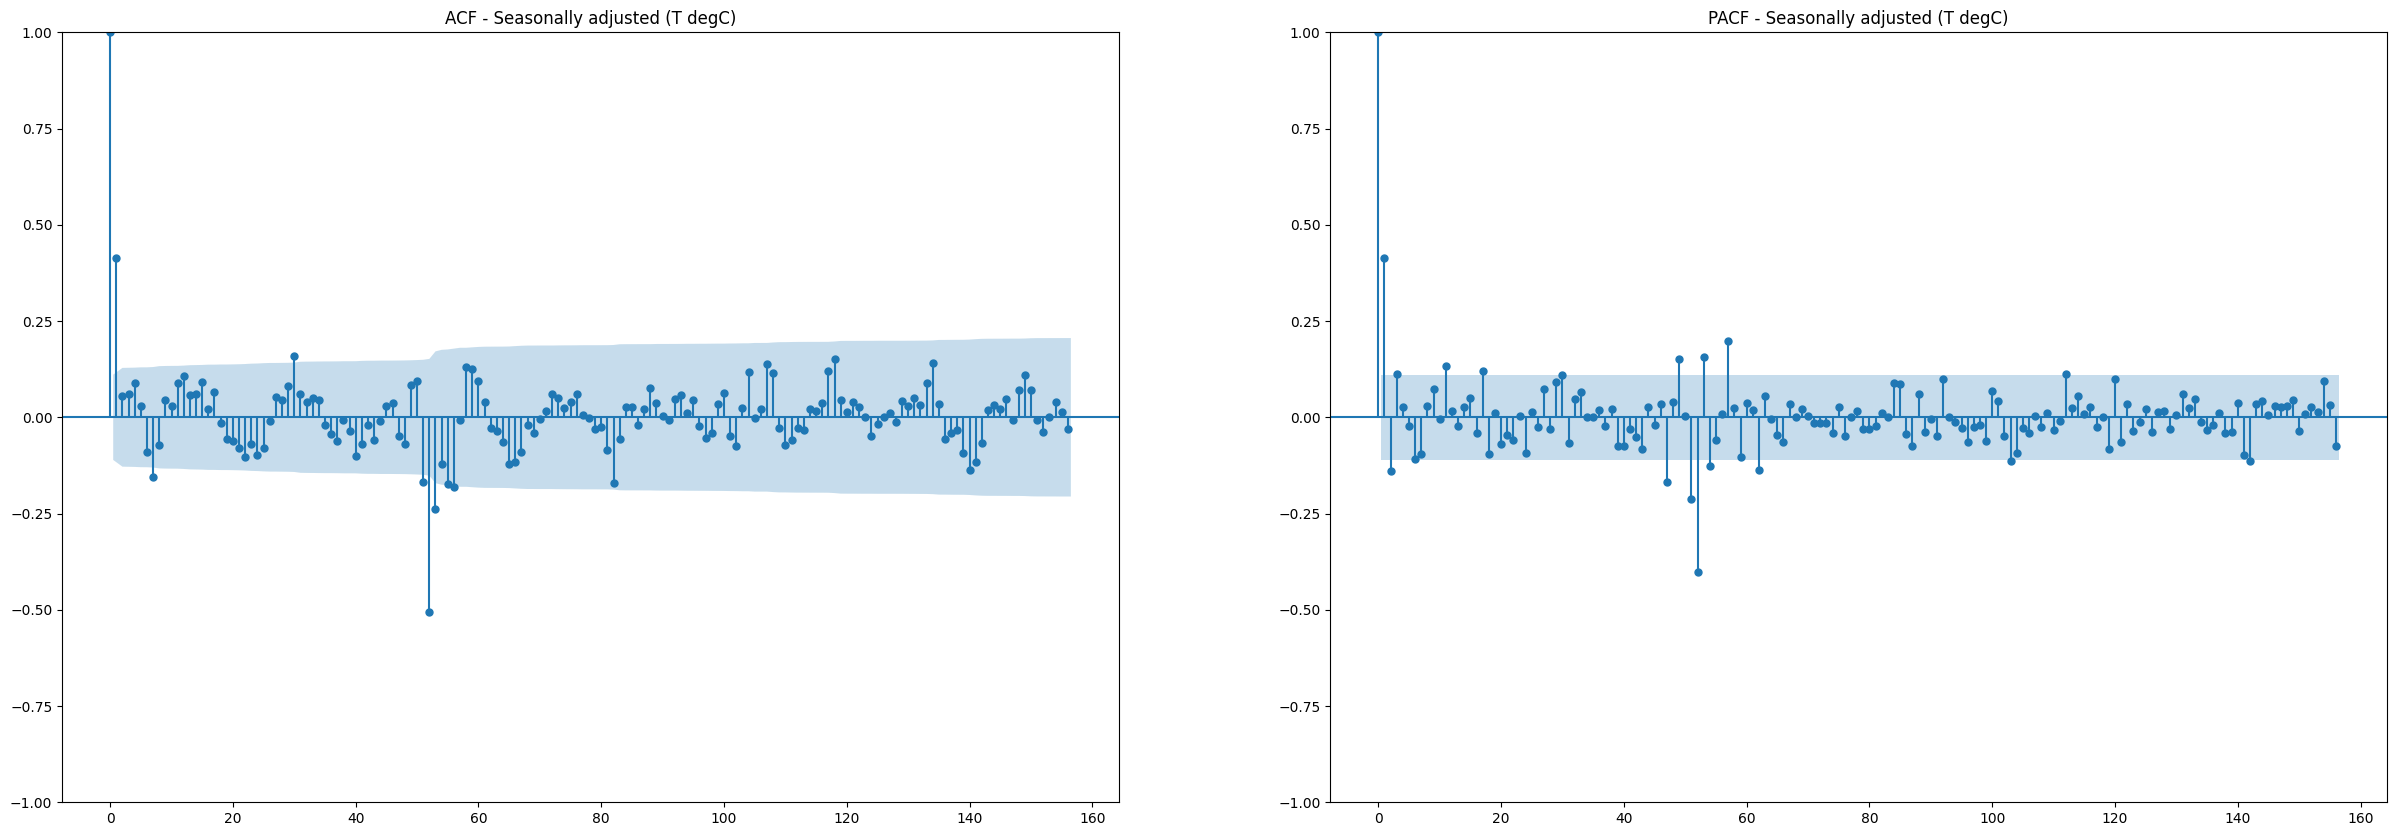

In [15]:
# we have to remove null values
w_train_seas_diff.dropna(inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(30,10))
plot_acf(w_train_seas_diff, lags=156, ax=ax[0], title='ACF - Seasonally adjusted (T degC)')
plot_pacf(w_train_seas_diff, lags=156, ax=ax[1], title='PACF - Seasonally adjusted (T degC)')
plt.show()

# CONCLUSION:

Our series is stationary, we have a strong seasonal component that we have to take in consideration.

We try to deseasonal using differet strategy such as the:

* SEASONAL DIFFERENTIATION 

* SERIES DECOMPOSITION 

Now we are ready to try to make some models 

In [19]:
%store w_train_seas_diff

Stored 'w_train_seas_diff' (Series)
